<a href="https://colab.research.google.com/github/Swarnavk18/Pneumonia-Detection-using-EfficientNetB0/blob/main/pneumonia_Detection_using_efficientnetB0_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing necessary Libraries

In [1]:
!pip install kaggle

In [2]:
#importing the dependencies
import os
import PIL as Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix ,classification_report

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adamax
from keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print('modules loaded')

modules loaded


In [3]:
!ls /content

sample_data


#Getting Dataset Ready

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:48<00:00, 23.4MB/s]
100% 2.29G/2.29G [01:48<00:00, 22.7MB/s]


In [6]:
!ls -l /content/chest-xray-pneumonia.zip

-rw-r--r-- 1 root root 2463365435 Sep 28  2019 /content/chest-xray-pneumonia.zip


In [7]:
#unZip the Zip file
from zipfile import ZipFile
dataset = '/content/chest-xray-pneumonia.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()

  print('The Dataset is Extracted!!')

The Dataset is Extracted!!


In [8]:
train_data_dir='/content/chest_xray/train'
filepaths=[]
labels=[]
folds=os.listdir(train_data_dir)

for fold in folds:
    fpath=os.path.join(train_data_dir,fold)
    fpaths=os.listdir(fpath)
    for f in fpaths:
        fpa=os.path.join(fpath,f)
        filepaths.append(fpa)
        labels.append(fold)
fseries=pd.Series(filepaths,name='filepaths')
lseries=pd.Series(labels,name='labels')
Dataset=pd.concat([fseries,lseries],axis=1)

In [9]:
Dataset

,filepaths,labels
0,/content/chest_xray/train/NORMAL/NORMAL2-IM-05...,NORMAL
1,/content/chest_xray/train/NORMAL/IM-0491-0001-...,NORMAL
2,/content/chest_xray/train/NORMAL/NORMAL2-IM-06...,NORMAL
3,/content/chest_xray/train/NORMAL/IM-0435-0001....,NORMAL
4,/content/chest_xray/train/NORMAL/NORMAL2-IM-08...,NORMAL
...,...,...
5211,/content/chest_xray/train/PNEUMONIA/person573_...,PNEUMONIA
5212,/content/chest_xray/train/PNEUMONIA/person447_...,PNEUMONIA
5213,/content/chest_xray/train/PNEUMONIA/person1642...,PNEUMONIA
5214,/content/chest_xray/train/PNEUMONIA/person1453...,PNEUMONIA


#Splitting into train & Dummy dataset

In [10]:
train_data , dummy_data=train_test_split(Dataset,test_size=0.2,shuffle=True,random_state=42)
valid_data,test_data=train_test_split(Dataset,test_size=0.4,shuffle=True,random_state=42)

#Plotting differents aspects of data

In [11]:
#counting the two different values
count_train=train_data['labels'].value_counts()
count_train

,count
labels,
PNEUMONIA,3118
NORMAL,1054


<ipython-input-12-dcfcd0f68bc6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_train.index,y=count_train.values,palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


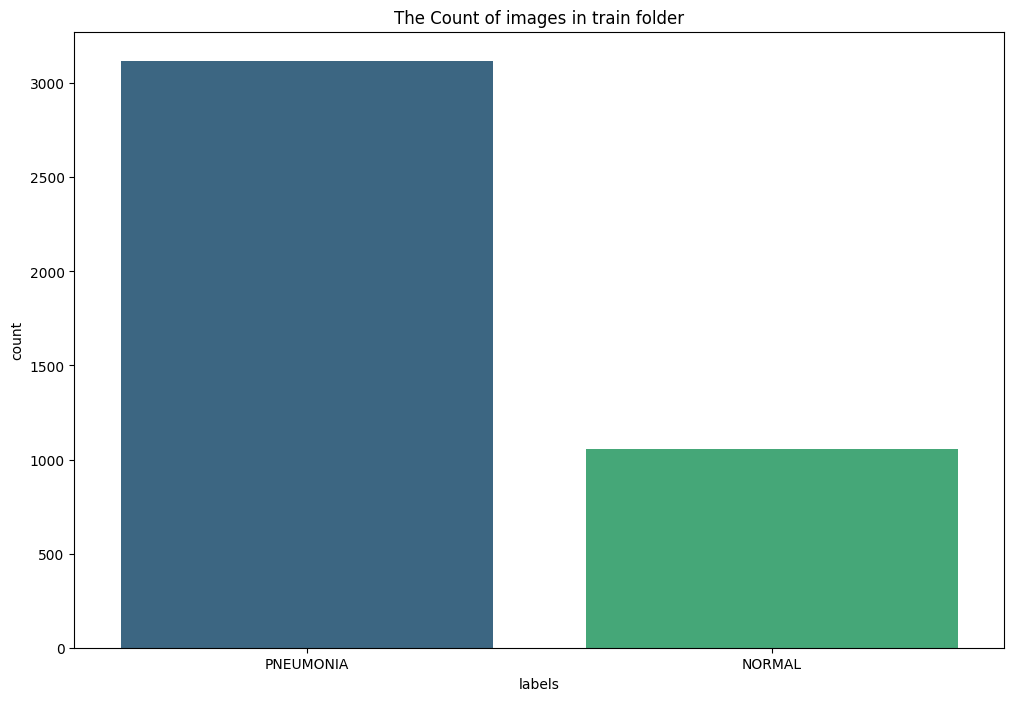

In [12]:
plt.figure(figsize=(12,8))
sns.barplot(x=count_train.index,y=count_train.values,palette='viridis')
plt.title('The Count of images in train folder')
plt.xlabel('labels')
plt.ylabel('count')
plt.show()

In [13]:
count_valid=valid_data['labels'].value_counts()
count_valid

,count
labels,
PNEUMONIA,2344
NORMAL,785


<ipython-input-14-a9c6a734d921>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_valid.index,y=count_valid.values,palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


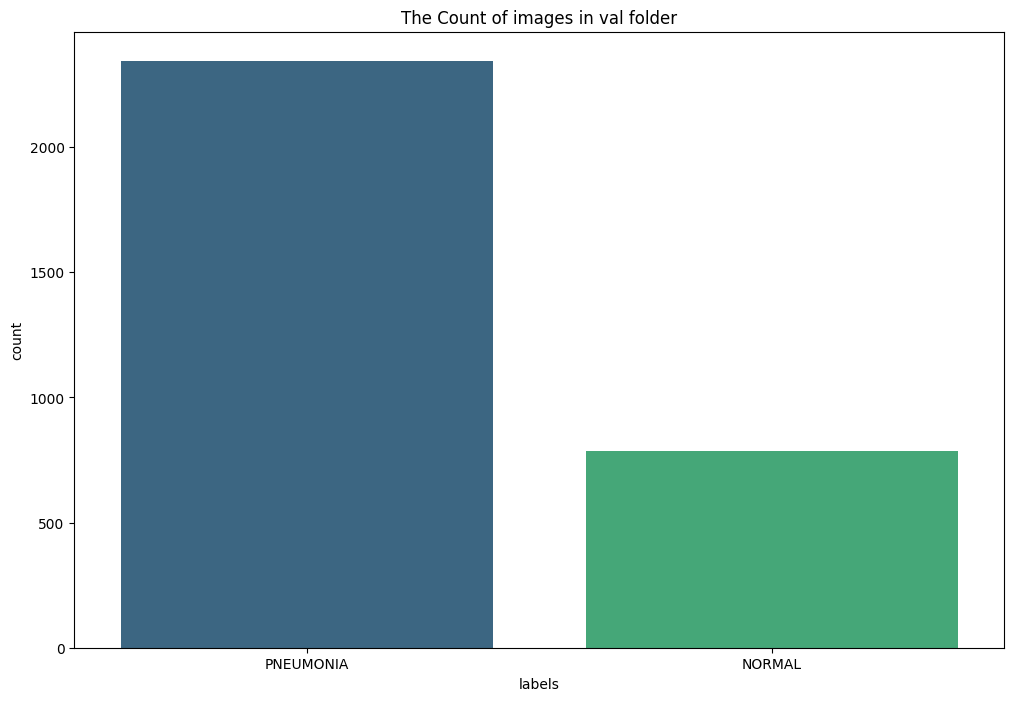

In [14]:
plt.figure(figsize=(12,8))
sns.barplot(x=count_valid.index,y=count_valid.values,palette='viridis')
plt.title('The Count of images in val folder')
plt.xlabel('labels')
plt.ylabel('count')
plt.show()

In [15]:
count_test=test_data['labels'].value_counts()
count_test

,count
labels,
PNEUMONIA,1531
NORMAL,556


<ipython-input-16-f1163db19c71>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_test.index,y=count_test.values,palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


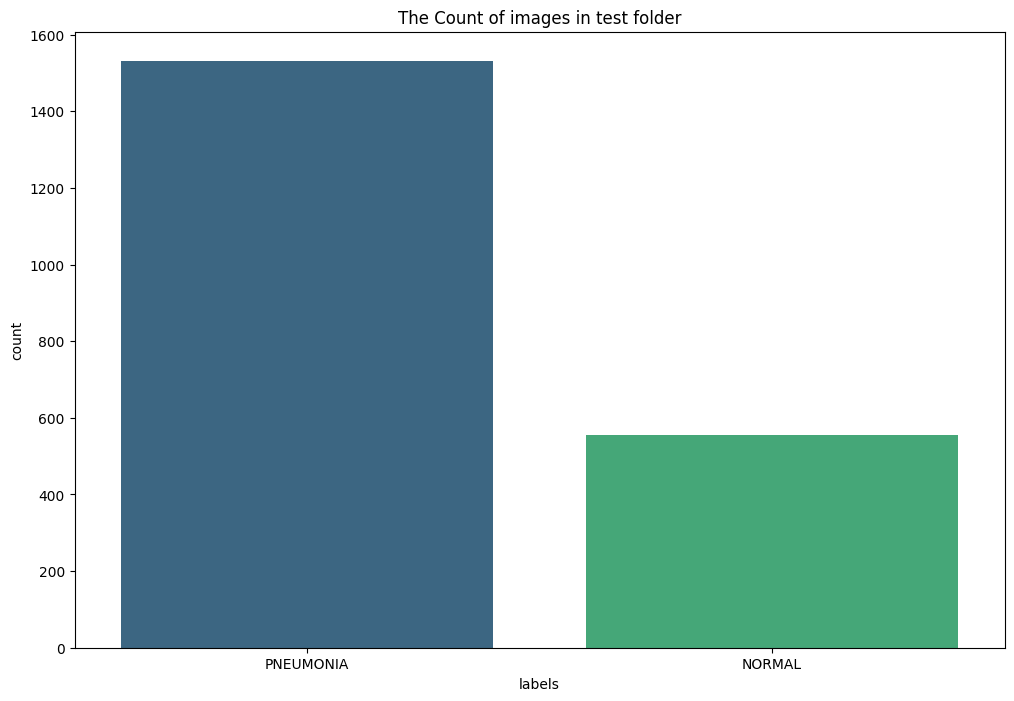

In [16]:
plt.figure(figsize=(12,8))
sns.barplot(x=count_test.index,y=count_test.values,palette='viridis')
plt.title('The Count of images in test folder')
plt.xlabel('labels')
plt.ylabel('count')
plt.show()

In [17]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_data, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_data, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_data, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 3129 validated image filenames belonging to 2 classes.
Found 2087 validated image filenames belonging to 2 classes.


#Sample Of Data

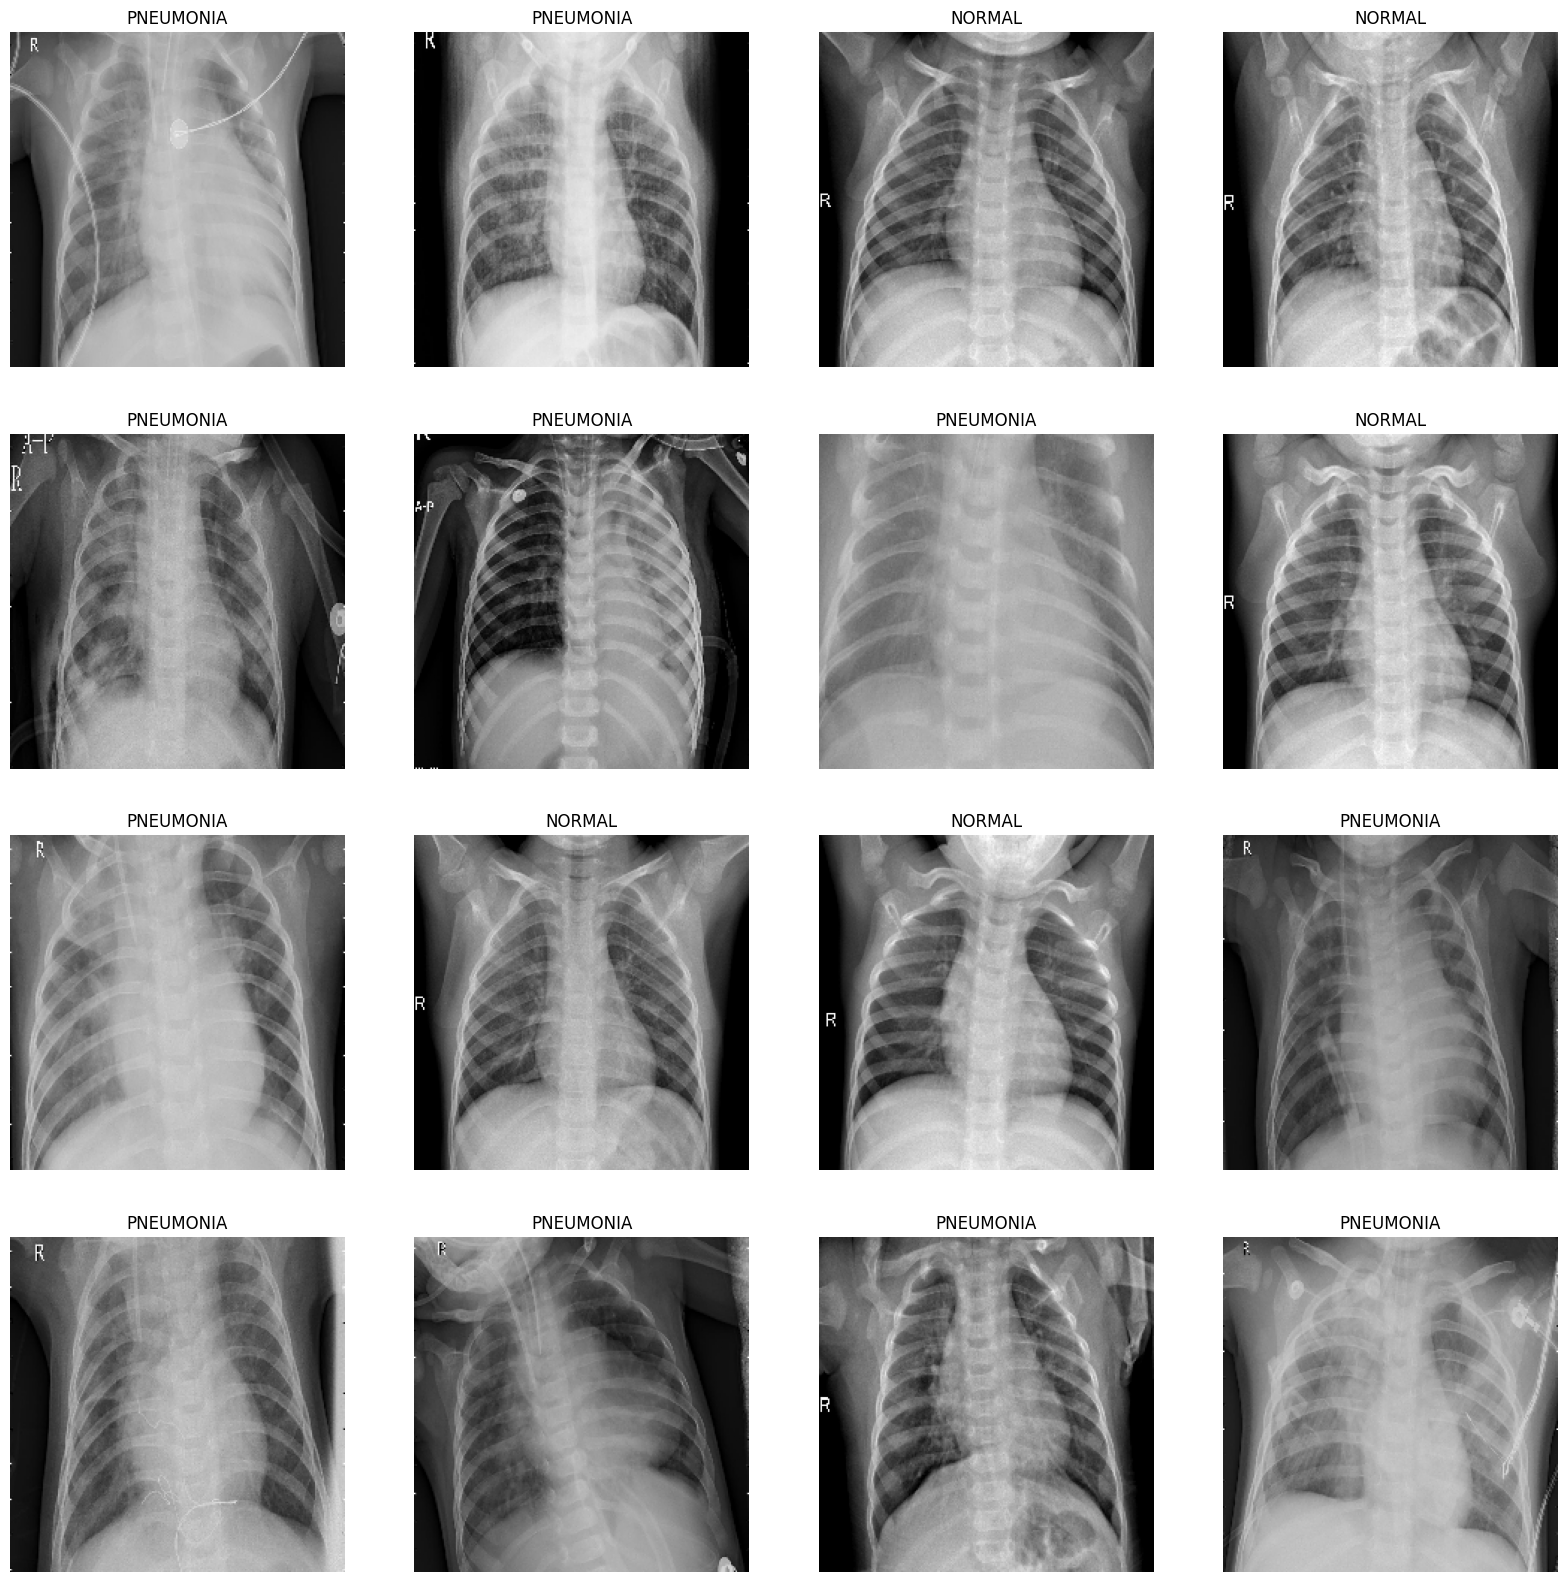

In [18]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'black', fontsize= 12)
    plt.axis('off')
plt.show()

#Model Creation

In [19]:
base_model=keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))
model=Sequential([
    base_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.25),
    Dense(64,activation='relu'),
    Dense(2,activation='softmax')
])
model.compile(Adamax(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [20]:
history=model.fit(train_gen,epochs=10,validation_data=valid_gen,shuffle=False,validation_steps=None)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


261/261 ━━━━━━━━━━━━━━━━━━━━ 218s 501ms/step - accuracy: 0.9002 - loss: 0.2546 - val_accuracy: 0.8955 - val_loss: 0.2562
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 74s 282ms/step - accuracy: 0.9897 - loss: 0.0342 - val_accuracy: 0.9249 - val_loss: 0.1906
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 87s 335ms/step - accuracy: 0.9979 - loss: 0.0157 - val_accuracy: 0.9300 - val_loss: 0.1731
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 76s 290ms/step - accuracy: 0.9948 - loss: 0.0151 - val_accuracy: 0.9984 - val_loss: 0.0067
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 73s 280ms/step - accuracy: 0.9952 - loss: 0.0128 - val_accuracy: 1.0000 - val_loss: 6.7523e-04
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 76s 290ms/step - accuracy: 0.9973 - loss: 0.0084 - val_accuracy: 1.0000 - val_loss: 4.2628e-04
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 86s 328ms/step - accuracy: 0.9970 - loss: 0.0073 - val_accuracy: 0.9997 - val_loss: 0.0017
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 75s 286ms/step - accuracy: 0.9979 - loss: 0.0

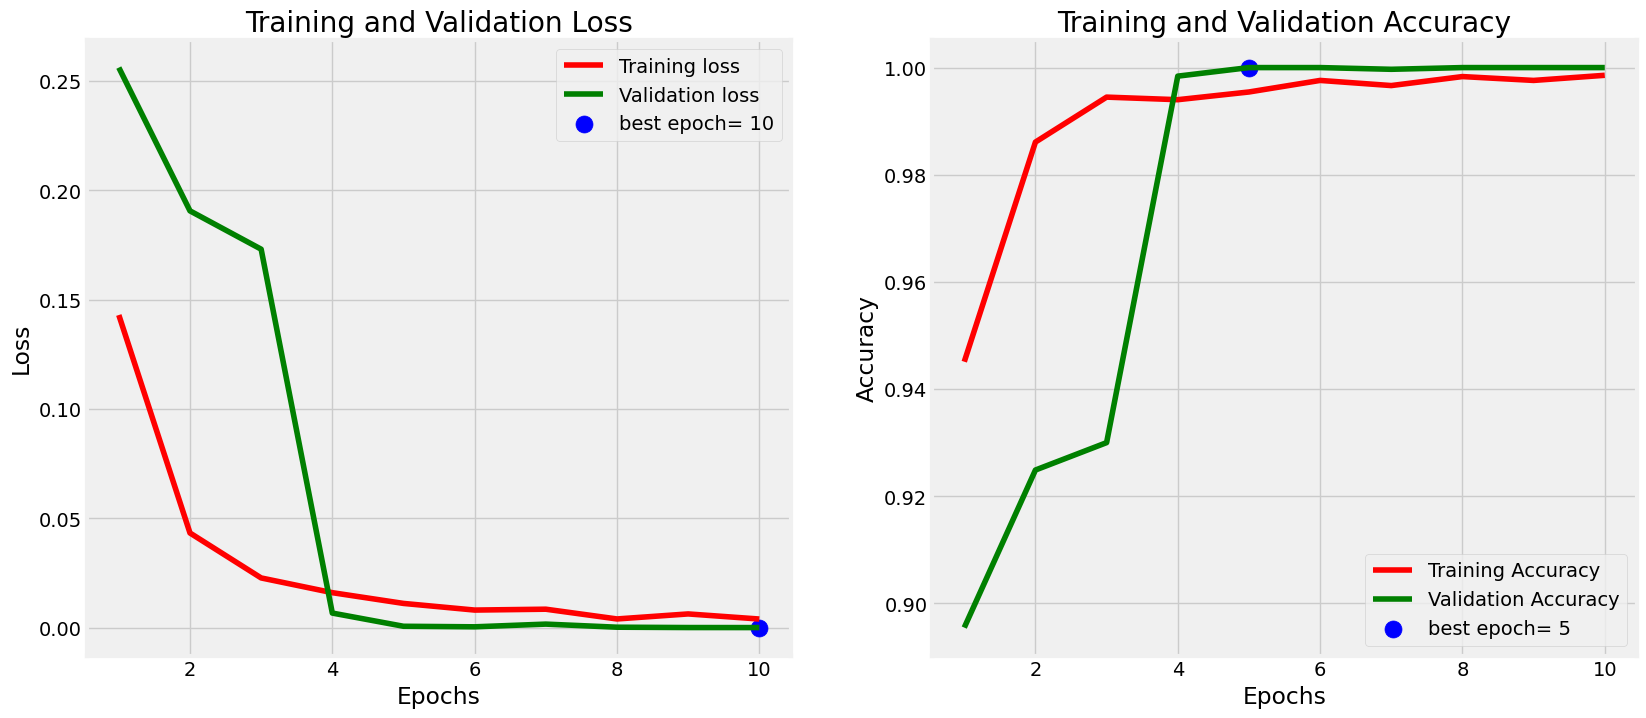

In [21]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [22]:
ts_length = len(test_data)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2087/2087 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - accuracy: 1.0000 - loss: 7.4329e-05  


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2087/2087 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 1.0000 - loss: 7.4278e-05  
   1/2087 ━━━━━━━━━━━━━━━━━━━━ 7:12 207ms/step - accuracy: 1.0000 - loss: 5.5180e-04

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2087/2087 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.9909 - loss: 0.0287  
Train Loss:  7.472014840459451e-05
Train Accuracy:  1.0
--------------------
Valid Loss:  7.479992927983403e-05
Valid Accuracy:  1.0
--------------------
Test Loss:  0.026993364095687866
Test Accuracy:  0.991375207901001


#Predictions

In [24]:
# preds = model.predict_generator(test_gen)
# y_pred = np.argmax(preds, axis=1)
preds = model.predict(test_gen) # Use model.predict instead of model.predict_generator
y_pred = np.argmax(preds, axis=1)

131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 208ms/step


#Confusion matrix

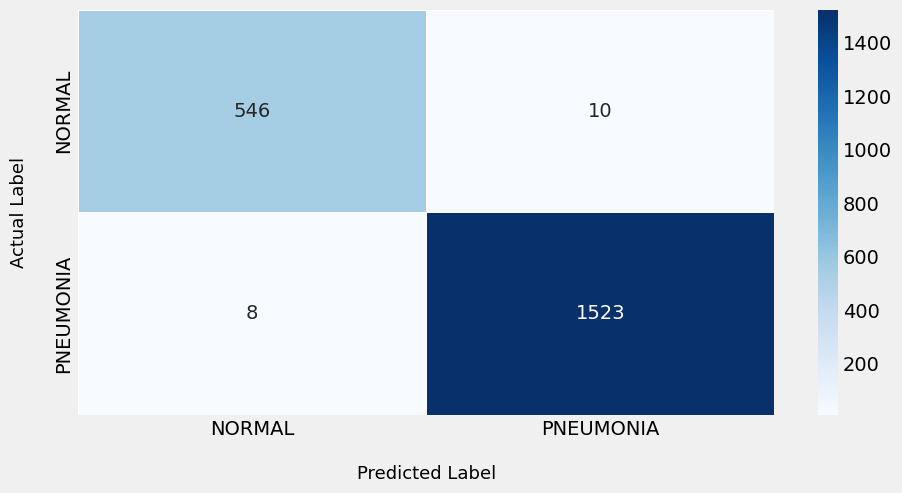

In [25]:
plt.figure(figsize=(10,5))
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);

#Classification Report

In [26]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      NORMAL       0.99      0.98      0.98       556
   PNEUMONIA       0.99      0.99      0.99      1531

    accuracy                           0.99      2087
   macro avg       0.99      0.99      0.99      2087
weighted avg       0.99      0.99      0.99      2087

